# Import Libraries, create constants and functions

## Libraries

In [70]:
!pip install numba=="0.57.1"
!pip install tsfresh
!pip install stock_predict_lib
import json
import yfinance as yf
import datetime
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tsfresh import extract_relevant_features, extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

SYMBOLS = {
      'AAPL': 0,
      'AMZN': 1,
      'NKE': 2,
      'PFE': 3,
      'TSLA': 4,
      'XOM': 5
    }

ERROR: Could not find a version that satisfies the requirement stock_predict_lib (from versions: none)
ERROR: No matching distribution found for stock_predict_lib


## Function to Get Price Data and ESG Scores

In [71]:
def get_data():
  df = pd.read_csv('/content/esg.csv')
  for symbol in SYMBOLS:
    new_df = df[df['Symbol'] == symbol]
    new_df.interpolate(limit_direction="both", inplace=True)
    df[df['Symbol'] == symbol] = new_df

  return df

# Getting the data

In [72]:
original_df = get_data()
original_df['Symbol'] = original_df['Symbol'].replace(SYMBOLS)
original_df

<ipython-input-71-2052551d30f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.interpolate(limit_direction="both", inplace=True)


,Symbol,Time,ESG,Governance,Environment,Social,Close
0,0,1504216800,67.190000,57.480000,83.730000,55.20,41.012501
1,0,1506808800,67.400000,52.680000,85.860000,56.80,41.367500
2,0,1509490800,67.400000,52.680000,85.860000,56.80,41.722500
3,0,1512082800,67.400000,52.680000,85.860000,56.80,42.762501
4,0,1514761200,68.540000,52.680000,88.700000,56.80,42.353750
...,...,...,...,...,...,...,...
355,5,1648764000,36.926667,8.140000,18.736667,10.06,83.120003
356,5,1651356000,36.460000,8.140000,18.510000,9.82,90.480000
357,5,1654034400,36.463333,8.126667,18.523333,9.82,97.839996
358,5,1656626400,36.466667,8.113333,18.536667,9.82,87.550003


## Visualizing the original DataFrame

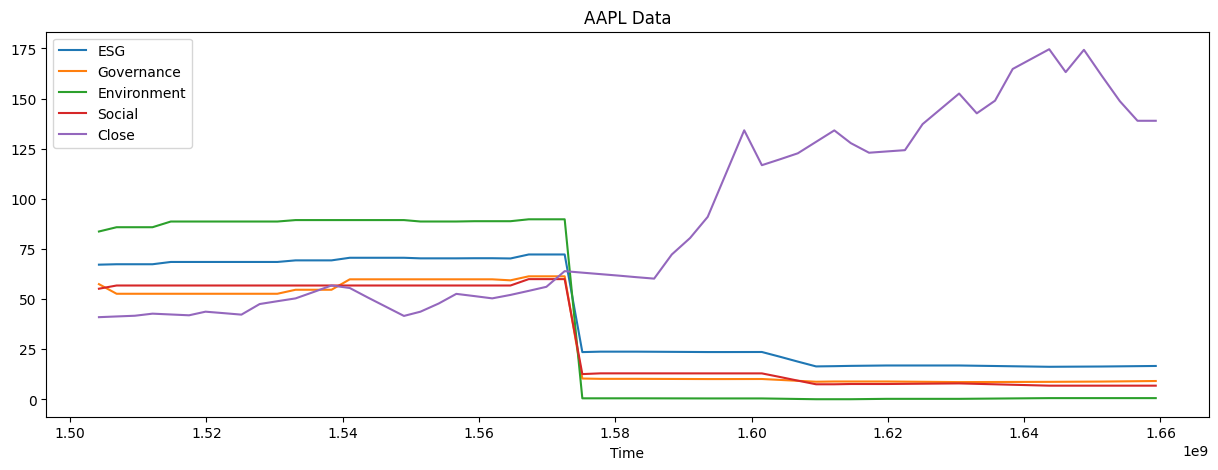

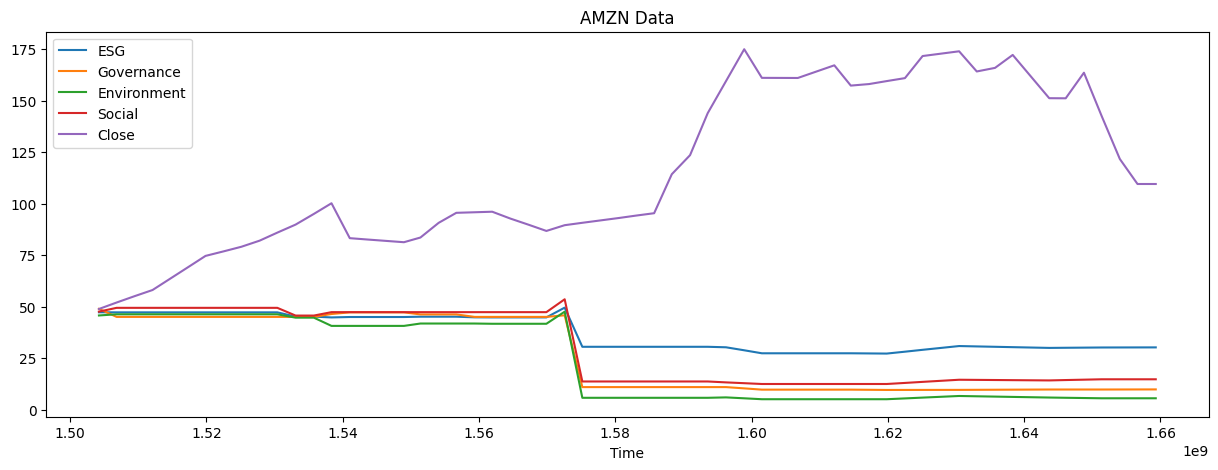

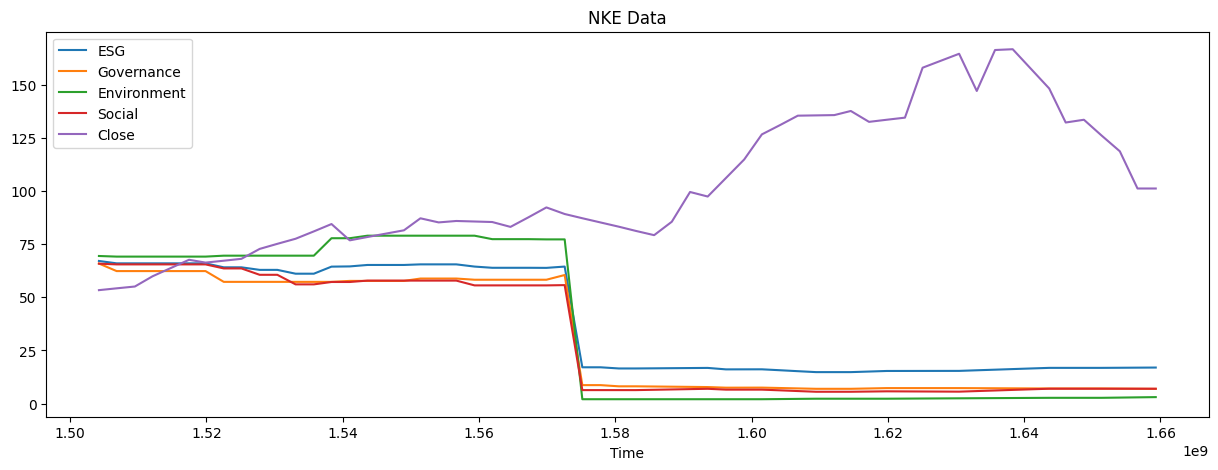

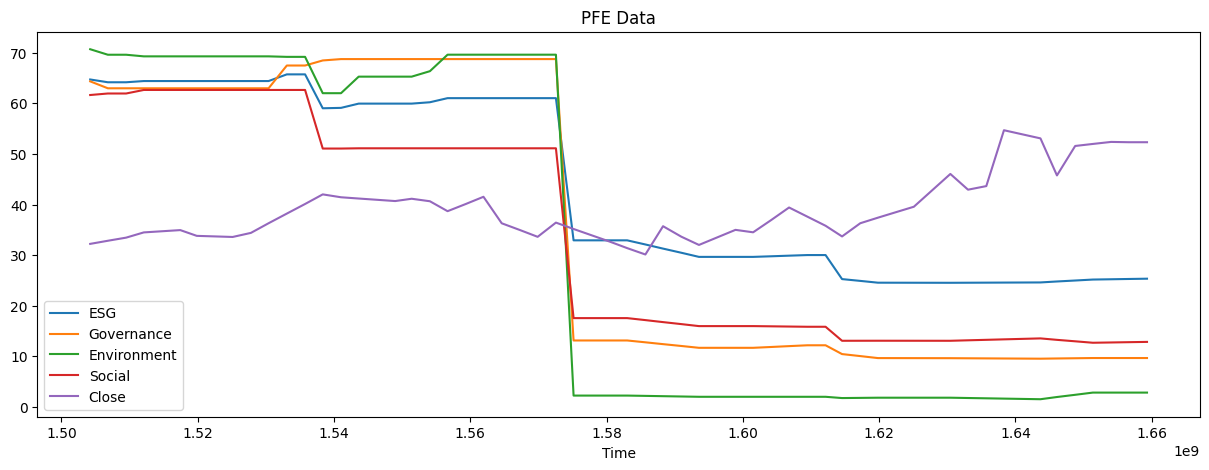

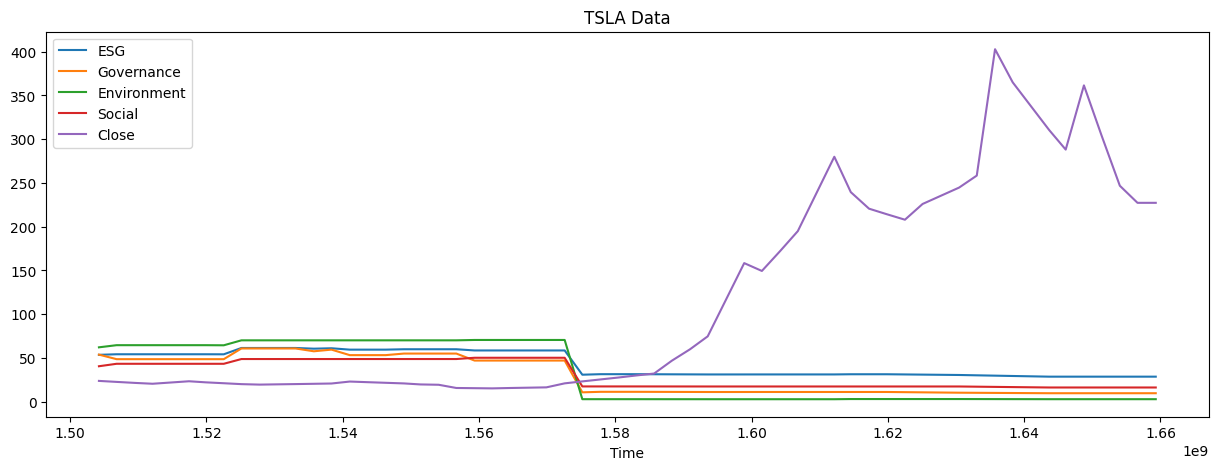

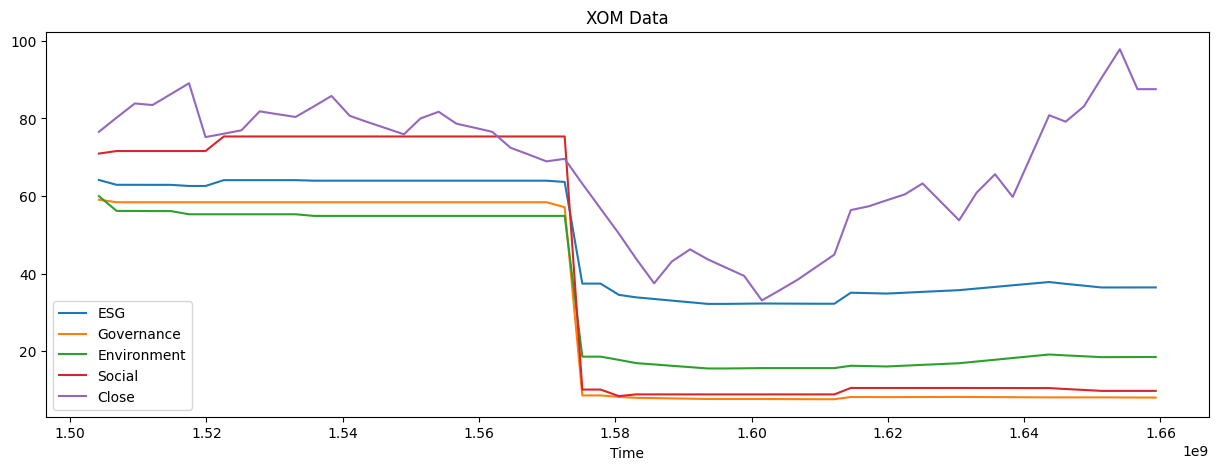

In [78]:
for symbol, value in SYMBOLS.items():
  original_df[original_df['Symbol'] == value].drop('Symbol', axis=1).plot(x='Time', figsize=(15, 5), title=f'{symbol} Data')
  plt.show()

## Creating Features and splitting the DataFrame

In [76]:
df_rolled = roll_time_series(original_df, column_id="Symbol", column_sort="Time")
df_rolled.drop('Symbol', axis=1, inplace=True)
df_rolled.drop('Time', axis=1, inplace=True)
df_rolled

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling:  93%|█████████▎| 56/60 [00:01<00:00, 35.29it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 60/60 [00:02<00:00, 28.39it/s]


,ESG,Governance,Environment,Social,Close,id
0,67.190000,57.480000,83.730000,55.20,41.012501,"(0, 1504216800)"
6,67.190000,57.480000,83.730000,55.20,41.012501,"(0, 1506808800)"
7,67.400000,52.680000,85.860000,56.80,41.367500,"(0, 1506808800)"
18,67.190000,57.480000,83.730000,55.20,41.012501,"(0, 1509490800)"
19,67.400000,52.680000,85.860000,56.80,41.367500,"(0, 1509490800)"
...,...,...,...,...,...,...
10950,36.926667,8.140000,18.736667,10.06,83.120003,"(5, 1659304800)"
10961,36.460000,8.140000,18.510000,9.82,90.480000,"(5, 1659304800)"
10964,36.463333,8.126667,18.523333,9.82,97.839996,"(5, 1659304800)"
10970,36.466667,8.113333,18.536667,9.82,87.550003,"(5, 1659304800)"


In [77]:
df_features = extract_features(df_rolled, column_id="id", column_sort="id", impute_function=impute)
df_features

Feature Extraction: 100%|██████████| 1800/1800 [02:04<00:00, 14.44it/s]


ESG__variance_larger_than_standard_deviation  \
0 1504216800                                           0.0   
  1506808800                                           0.0   
  1509490800                                           0.0   
  1512082800                                           0.0   
  1514761200                                           0.0   
...                                                    ...   
5 1648764000                                           1.0   
  1651356000                                           1.0   
  1654034400                                           1.0   
  1656626400                                           1.0   
  1659304800                                           1.0   

              ESG__has_duplicate_max  ESG__has_duplicate_min  \
0 1504216800                     0.0                     0.0   
  1506808800                     0.0                     0.0   
  1509490800                     1.0                     0.0   
  1512082800                     1.0                     0.0   
  1514761200                     0.0                     0.0   
...                              ...                     ...   
5 1648764000                     0.0                     1.0   
  1651356000                     0.0                     1.0   
  1654034400                     0.0                     1.0   
  1656626400                     0.0                     1.0   
  1659304800                     0.0                     1.0   

              ESG__has_duplicate  ESG__sum_values  ESG__abs_energy  \
0 1504216800                 0.0        67.190000      4514.496100   
  1506808800                 0.0       134.590000      9057.256100   
  1509490800                 1.0       201.990000     13600.016100   
  1512082800                 1.0       269.390000     18142.776100   
  1514761200                 1.0       337.930000     22840.507700   
...                          ...              ...              ...   
5 1648764000                 1.0      2727.805000    144759.895496   
  1651356000                 1.0      2764.265000    146089.227096   
  1654034400                 1.0      2800.728333    147418.801774   
  1656626400                 1.0      2837.195000    148748.619552   
  1659304800                 1.0      2873.665000    150078.680452   

              ESG__mean_abs_change  ESG__mean_change  \
0 1504216800              1.908192         -0.475256   
  1506808800              0.210000          0.210000   
  1509490800              0.105000          0.105000   
  1512082800              0.070000          0.070000   
  1514761200              0.337500          0.337500   
...                            ...               ...   
5 1648764000              1.881515         -0.494970   
  1651356000              1.798036         -0.494464   
  1654034400              2.739415         -0.485731   
  1656626400              2.723276         -0.477299   
  1659304800              1.750480         -0.469153   

              ESG__mean_second_derivative_central  ESG__median  ...  \
0 1504216800                            -0.005435       67.190  ...   
  1506808800                            -0.005435       67.295  ...   
  1509490800                            -0.105000       67.400  ...   
  1512082800                            -0.052500       67.400  ...   
  1514761200                             0.155000       67.400  ...   
...                                           ...          ...  ...   
5 1648764000                             0.275586       37.660  ...   
  1651356000                             0.265727       37.460  ...   
  1654034400                             0.028088       37.460  ...   
  1656626400                             0.027624       37.460  ...   
  1659304800                             0.267917       37.451  ...   

              Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0 1504216800                        0.566086        

In [68]:
df_features_filtered = df_features.copy()
df_features_filtered.reset_index(inplace=True)
df_features_filtered['Symbol'] = df_features_filtered['level_0']
df_features_filtered['Time'] = df_features_filtered['level_1']
df_features_filtered.drop('level_0', axis=1, inplace=True)
df_features_filtered.drop('level_1', axis=1, inplace=True)
df_features_filtered

,ESG__variance_larger_than_standard_deviation,ESG__has_duplicate_max,ESG__has_duplicate_min,ESG__has_duplicate,ESG__sum_values,ESG__abs_energy,ESG__mean_abs_change,ESG__mean_change,ESG__mean_second_derivative_central,ESG__median,...,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7,Symbol,Time
0,0.0,0.0,0.0,0.0,67.190000,4514.496100,1.908192,-0.475256,-0.005435,67.190,...,1.844550,1.497578,2.250328,2.752287,3.029479,3.127893,0.0,84.772143,0,1504216800
1,0.0,0.0,0.0,0.0,134.590000,9057.256100,0.210000,0.210000,-0.005435,67.295,...,-0.000000,1.497578,2.250328,2.752287,3.029479,3.127893,0.0,84.772143,0,1506808800
2,0.0,1.0,0.0,1.0,201.990000,13600.016100,0.105000,0.105000,-0.105000,67.400,...,0.693147,-0.000000,2.250328,2.752287,3.029479,3.127893,0.0,84.772143,0,1509490800
3,0.0,1.0,0.0,1.0,269.390000,18142.776100,0.070000,0.070000,-0.052500,67.400,...,1.098612,-0.000000,-0.000000,2.752287,3.029479,3.127893,0.0,84.772143,0,1512082800
4,0.0,0.0,0.0,1.0,337.930000,22840.507700,0.337500,0.337500,0.155000,67.400,...,1.098612,0.636514,0.693147,-0.000000,3.029479,3.127893,0.0,84.772143,0,1514761200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1.0,0.0,1.0,1.0,2727.805000,144759.895496,1.881515,-0.494970,0.275586,37.660,...,1.777137,1.612069,2.591505,3.349813,3.741550,3.856571,0.0,84.956429,5,1648764000
356,1.0,0.0,1.0,1.0,2764.265000,146089.227096,1.798036,-0.494464,0.265727,37.460,...,2.058565,1.613714,2.642058,3.433828,3.706449,3.795914,0.0,86.010714,5,1651356000
357,1.0,0.0,1.0,1.0,2800.728333,147418.801774,2.739415,-0.485731,0.028088,37.460,...,2.347391,1.592505,2.567618,3.300848,3.662825,3.844606,0.0,88.113571,5,1654034400
358,1.0,0.0,1.0,1.0,2837.195000,148748.619552,2.723276,-0.477299,0.027624,37.460,...,2.499654,1.686025,2.777529,3.629253,3.834951,3.970292,0.0,88.697857,5,1656626400


In [52]:
y = original_df[['Close', 'Symbol', 'Time', 'ESG']]
y.index = df_features_filtered.index
X_train, X_test, y_train, y_test = train_test_split(df_features_filtered, y['Close'], test_size=0.2, shuffle=True)

# Building the model


In [ ]:
ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.16, loss='square')
ada.fit(df_features_filtered, y['Close'])

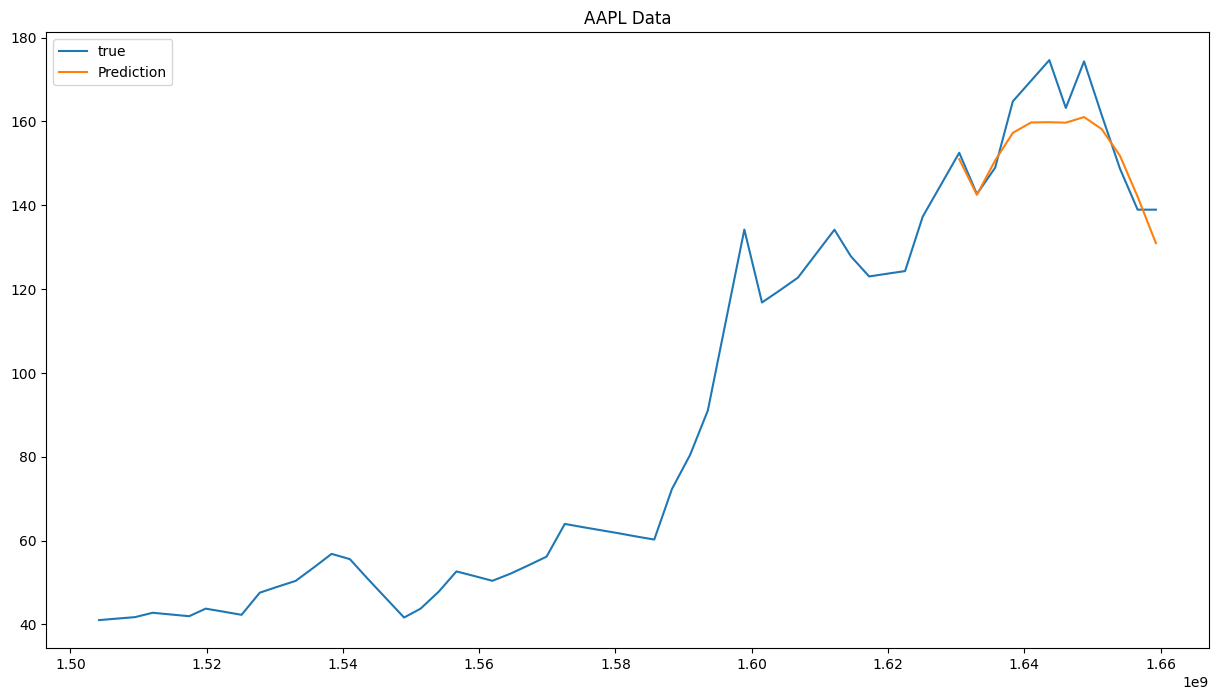

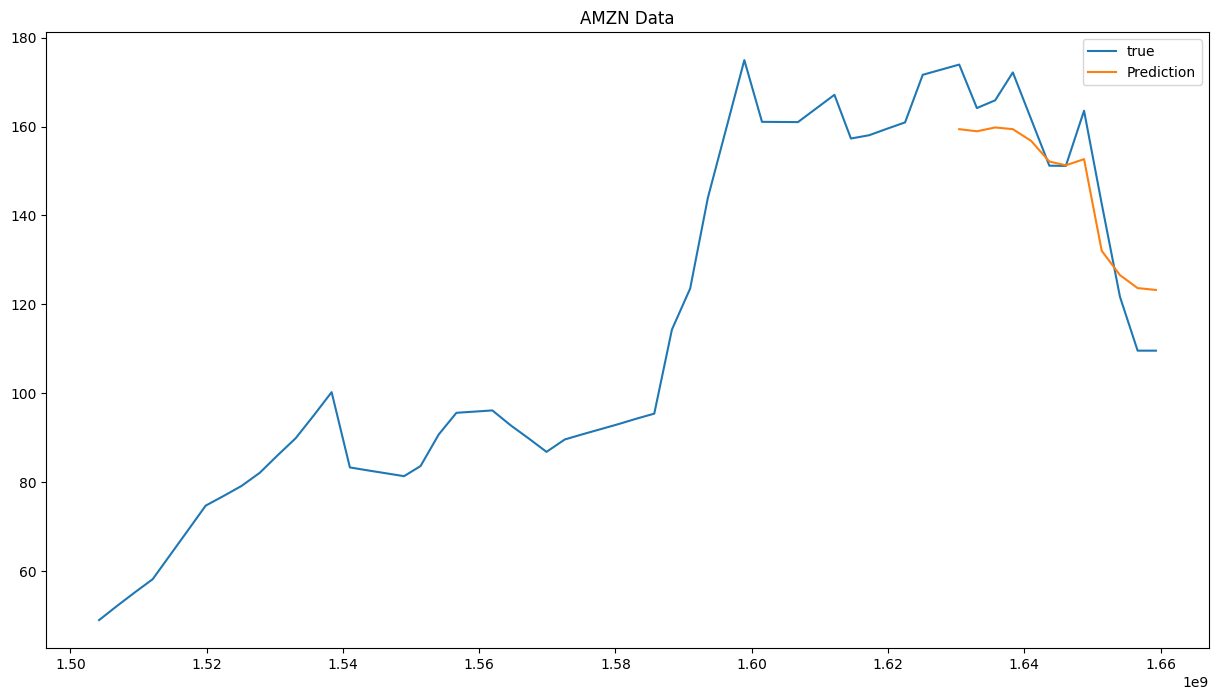

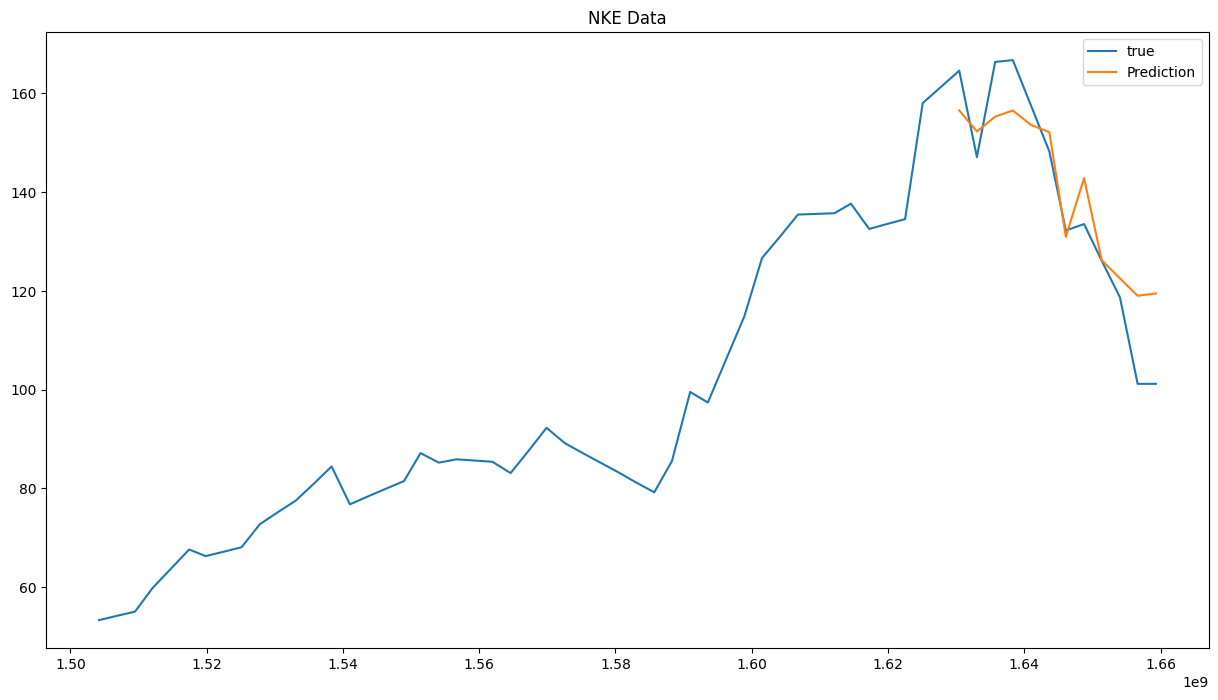

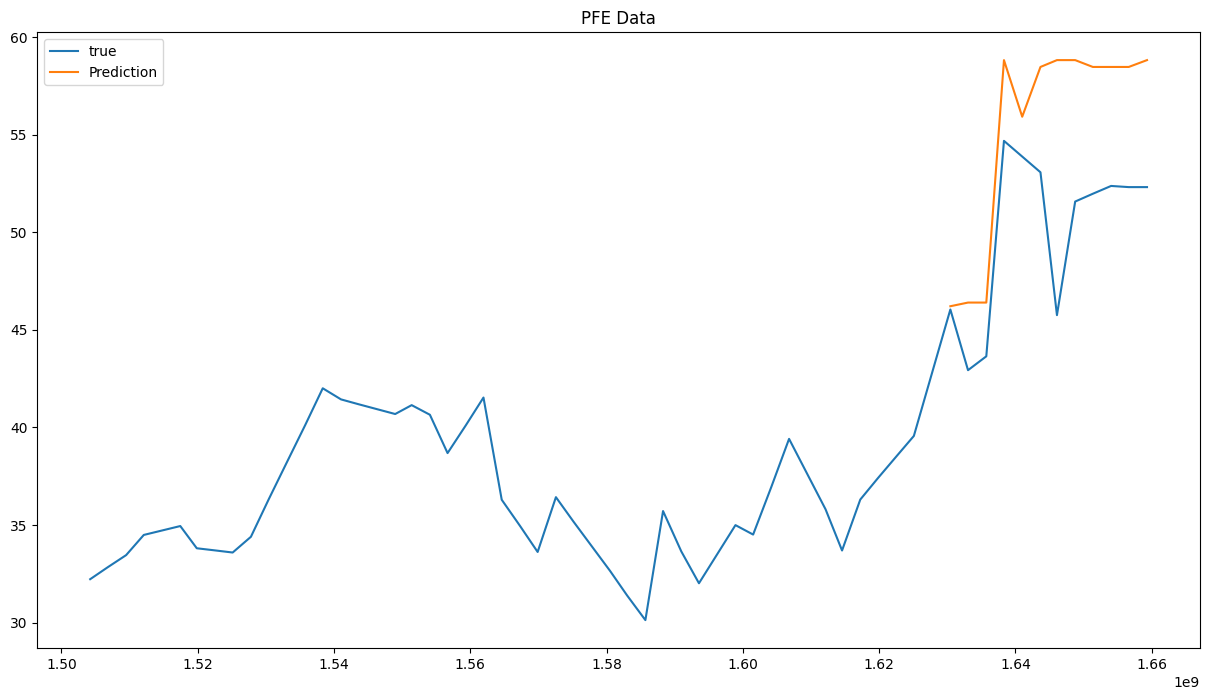

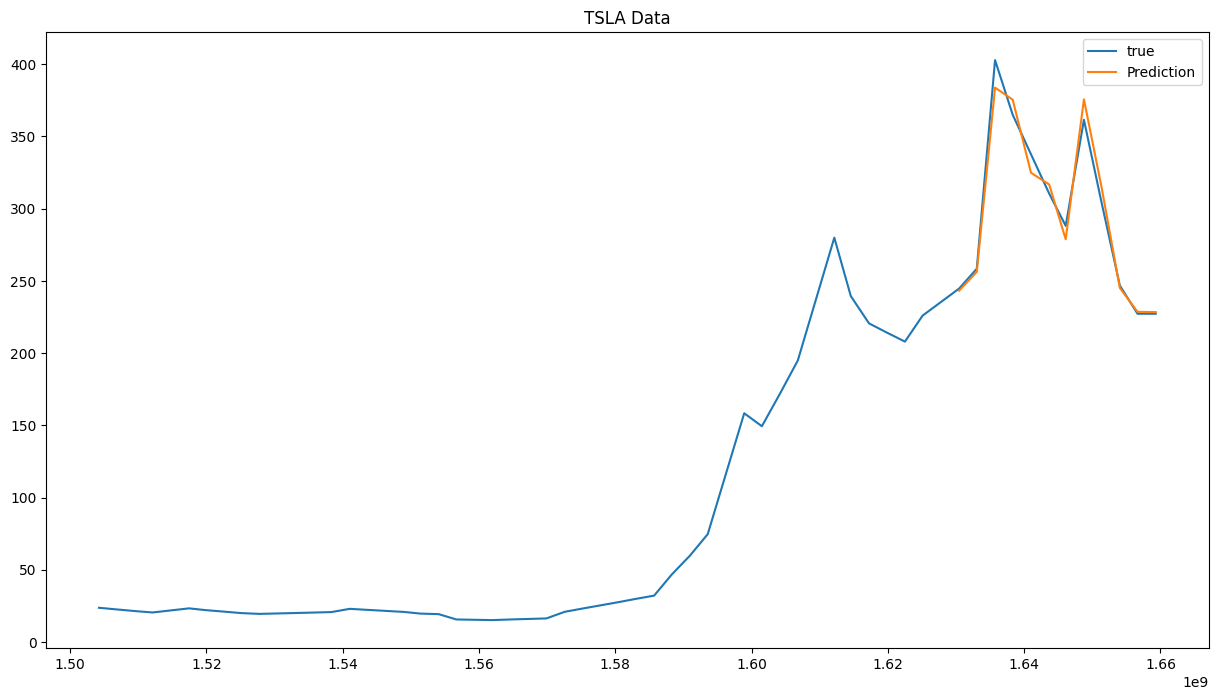

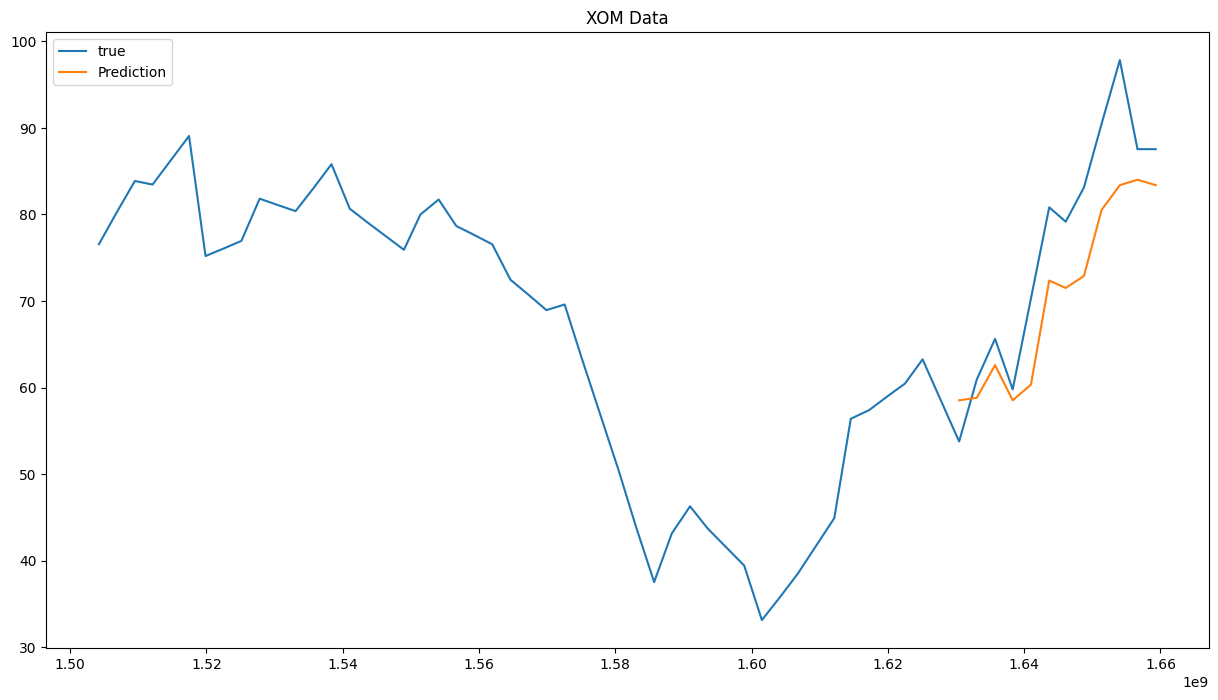

In [80]:
for symbol, value in SYMBOLS.items():
  symbol_values = df_features_filtered[df_features_filtered['Symbol'] == value]
  split = int(len(symbol_values)*0.8)
  y_pred = ada.predict(symbol_values[split:])
  y_pred = pd.Series(data=y_pred, index=symbol_values[split:].index)
  original_data = original_df[original_df['Symbol'] == value]
  plt.figure(figsize=(15, 8))
  plt.plot(original_data['Time'], original_data['Close'], label="true")
  plt.plot(original_data['Time'][split:], y_pred, label="Prediction")
  plt.legend()
  plt.title(f'{symbol} Data')
  plt.show()